# IST 718 Big Data Analytics
## Project Group 7- Rental Price Prediction

## Group Members: 
## Srinath Ramachandran, Aarthe Jayaprakash, Mohit Gupta, Satyen Amonkar


## Loading Packages

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np
import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql
import matplotlib.pyplot as plt
import pandas as pd

## Creating Spark Sessions 

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Loading data 

In [3]:
#The data is loaded into an rdd in an unstructured format
#this is done so that the data can be of the correct format to be loaded into a PySpark Dataframe
rdd = sc.textFile('inputFile.csv')
df=spark.read.csv('inputFile.csv', inferSchema=True,header=True)

## Initial Number of Columns 

In [4]:
colnames= df.columns
len(colnames)

29

In [5]:
#The header is removed from the rdd
tagsheader = rdd.first()
header = sc.parallelize([tagsheader])
data = rdd.subtract(header)

## Function for cleaning Columns containing commas

In [6]:
# PySpark has an option to ignore commas within quotes while reading a csv.
# the amenities column has multiple commas and quotes within {} 
# This function replaces the extra quotes within {} in amenities with a blank 

def removequotes(line):
    flag=0
    line1=''
    for x in line:
        if flag==0:
            if x=='\{':
                flag=1
        else:
            if x=='}':
                flag=0
            x=x.replace('\"','')
        line1=line1+x
    return line1


In [7]:
# the removequotes function is applied to every entry in the rdd
data=data.map(removequotes)


In [8]:
# the modified data is stored in a csv
data.saveAsTextFile('tempFile.csv')

## Loading Data by ignoring commas inside quotes 

In [9]:
#the data is reloaded into a spark dataframe
# quotes are defined as escape character
df1=spark.read.option("quote", "\"").option("escape", "\"").csv("tempFile.csv")

In [10]:
new=df1.toDF(*colnames)

## Handling Null Values

In [11]:
new=new.na.drop()

## Dropping non-essential columns

In [12]:
#These columns either don't contribute value to the analysis or have too many null values. 

new=new.drop('description',
           'first_review',
            'host_has_profile_pic',
            'name',
            'thumbnail_url','zipcode','id','cleaning_fee'
           'last_review',
             'latitude',
             'longitude')

## Converting Host Response Rate from Percent to Decimal Value

In [13]:
new = new.withColumn('host_response_rate',fn.regexp_replace('host_response_rate','%',''))
new= new.withColumn('host_response_rate', (fn.col('host_response_rate').cast('float')))
new = new.withColumn('host_response_rate',fn.col('host_response_rate')/100)

## Converting Log price to Price

In [14]:
# The inputFile contained log price, we converted it into price(USD) so that the rmse will be more interpretable.
from pyspark.sql import functions as fn
new = new.withColumn('price',fn.exp(fn.col('log_price')))


## Rounding Price value

In [15]:
new = new.withColumn('price',fn.round(fn.col('price')))

## Changing to appropriate datatypes from String


In [16]:
new= new.withColumn('accommodates', (fn.col('accommodates').cast('int')))
new= new.withColumn('bathrooms', (fn.col('bathrooms').cast('int')))
new= new.withColumn('cleaning_fee', (fn.col('cleaning_fee').cast('int')))
new= new.withColumn('number_of_reviews', (fn.col('number_of_reviews').cast('int')))
new= new.withColumn('review_scores_rating', (fn.col('review_scores_rating').cast('int')))
new= new.withColumn('bedrooms', (fn.col('bedrooms').cast('int')))
new= new.withColumn('beds', (fn.col('beds').cast('int')))

In [17]:
pre_process_data = new.select('amenities','property_type','room_type','accommodates','bathrooms','bedrooms','cancellation_policy','host_identity_verified','number_of_reviews',
                              'review_scores_rating','beds','cleaning_fee','host_response_rate','instant_bookable','host_since','city','price')

## Convert Host Response Rate to Decimal


In [18]:

pre_process_data = pre_process_data.withColumn('host_response_rate',fn.regexp_replace('host_response_rate','%',''))
pre_process_data= pre_process_data.withColumn('host_response_rate', (fn.col('host_response_rate').cast('float')))
pre_process_data = pre_process_data.withColumn('host_response_rate',fn.col('host_response_rate')/100)

## Feature Engineering

In [19]:
# Converted Property type, Room type and Cancellation Policy into dummy variables. 

pre_process_data=pre_process_data.withColumn('Apartment', (fn.col('property_type')=='Apartment').cast('int')).\
withColumn('House', (fn.col('property_type')=='House').cast('int')).\
withColumn('Condominium', (fn.col('property_type')=='Condominium').cast('int')).\
withColumn('Loft', (fn.col('property_type')=='Loft').cast('int')).\
withColumn('Townhouse', (fn.col('property_type')=='Townhouse').cast('int')).\
withColumn('Entire_home_apt', (fn.col('room_type')=='Entire home/apt').cast('int')).\
withColumn('Private_room', (fn.col('room_type')=='Private room').cast('int')).\
withColumn('NYC', (fn.col('city')=='NYC').cast('int')).\
withColumn('LA', (fn.col('city')=='LA').cast('int')).\
withColumn('Chicago', (fn.col('city')=='Chicago').cast('int')).\
withColumn('Boston', (fn.col('city')=='Boston').cast('int')).\
withColumn('SF', (fn.col('city')=='SF').cast('int')).\
withColumn('DC', (fn.col('city')=='DC').cast('int')).\
withColumn('Shared_room', (fn.col('city')=='Shared room').cast('int')).\
withColumn('flexible', (fn.col('cancellation_policy')=='flexible').cast('int')).\
withColumn('moderate', (fn.col('cancellation_policy')=='moderate').cast('int')).\
withColumn('strict', (fn.col('cancellation_policy')=='strict').cast('int'))


### Handling Column: Days since Host 

In [20]:
#Converted date to days.

pre_process_data=pre_process_data.withColumn("host_since_days",  fn.datediff(fn.current_date(), fn.col("host_since")))

### Handling Column: Amenities

In [21]:
amens =  ['24-hour check-in','Air conditioning','Buzzer/wireless intercom',
 'Cable TV','Carbon monoxide detector','Family/kid friendly','Fire extinguisher','First aid kit','Free parking on premises','Hair dryer',
'Indoor fireplace','Laptop friendly workspace','Lock on bedroom door','Pets allowed','Pets live on this property','Private entrance',
 'Safety card', 'Self Check-In','Smoke detector','Wireless Internet']

for column in amens:
    pre_process_data= pre_process_data.withColumn(column,fn.col("amenities").rlike(column))
    pre_process_data= pre_process_data.withColumn(column,fn.col(column).cast('int'))
    

### Converting Boolean Values into Integer, for Instant_bookable and host_identity verified

In [22]:
pre_process_data = pre_process_data.withColumn('instant_bookable',fn.regexp_replace('instant_bookable','t','1'))
pre_process_data = pre_process_data.withColumn('instant_bookable',fn.regexp_replace('instant_bookable','f','0'))
pre_process_data= pre_process_data.withColumn('instant_bookable', (fn.col('instant_bookable').cast('int')))

In [23]:
pre_process_data = pre_process_data.withColumn('host_identity_verified',fn.regexp_replace('host_identity_verified','t','1'))
pre_process_data = pre_process_data.withColumn('host_identity_verified',fn.regexp_replace('host_identity_verified','f','0'))
pre_process_data= pre_process_data.withColumn('host_identity_verified', (fn.col('host_identity_verified').cast('int')))
pre_process_data= pre_process_data.withColumn('host_identity_verified', (fn.col('host_identity_verified').cast('int')))
pre_process_data= pre_process_data.withColumn('host_identity_verified', (fn.col('host_identity_verified').cast('int')))

## Removing columns after Feature Engineering

In [24]:
pre_process_data= pre_process_data.drop('host_response_rate','amenities','property_type','room_type','cancellation_policy','city','log_price','host_since')

## Exploratory Data Analysis 
The frequency distribution of the data in each city and the distrubution of prices of vacation rentals are depicted below.

In [25]:
sf= pre_process_data.select(fn.sum('SF')).collect()
nyc= pre_process_data.select(fn.sum('NYC')).collect()
la=  pre_process_data.select(fn.sum('LA')).collect()
boston= pre_process_data.select(fn.sum('Boston')).collect()
dc= pre_process_data.select(fn.sum('DC')).collect()
chicago= pre_process_data.select(fn.sum('Chicago')).collect()


In [26]:
from pyspark.sql import Row
from pyspark.sql import SQLContext
l = [('SF',sf[0][0]),('NYC',nyc[0][0]),('LA',la[0][0]),('Boston',boston[0][0]),('DC',dc[0][0]),('Chicago',chicago[0][0])]
rdd = sc.parallelize(l)
city_tally = rdd.map(lambda x: Row(City=x[0], Count=int(x[1])))


In [27]:
city_count=city_tally.toDF()
city_count=city_count.toPandas()

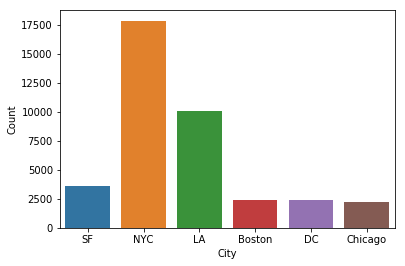

In [28]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='City',y='Count',data=city_count)
plt.show()

In [29]:
# We found that most of the listings are NYC and LA

In [30]:
pre_process_data.select('price').summary().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             38500|
|   mean|146.11901298701298|
| stddev| 130.8205562603637|
|    min|               1.0|
|    25%|              74.0|
|    50%|             110.0|
|    75%|             175.0|
|    max|            1999.0|
+-------+------------------+



In [31]:
#The data is right-skewed

In [32]:
price=pre_process_data.select('price').collect()
pricelist = [int(row.price) for row in price]

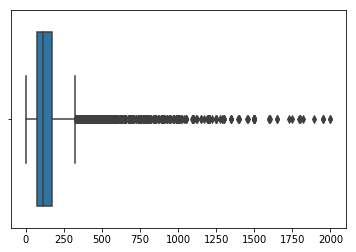

In [33]:
sns.boxplot(pricelist)
plt.show()

In [34]:
# The outliers are removed

In [35]:
pre_process_data=pre_process_data.filter(fn.col('price')<175)

## Splitting Pre-Processed data into Train, Validation And Test

### Splitting data into 60%(Training) 30%(Validation) and 10% (Test)

In [36]:
splits=pre_process_data.randomSplit([0.6,0.3,0.1])
train=splits[0]
validation=splits[1]
test=splits[2]
print(train.count())
print(validation.count())
print(test.count())

17100
8528
2928


In [37]:

inputf = ['accommodates','bathrooms','bedrooms','host_identity_verified','number_of_reviews','review_scores_rating',
                                      'beds','instant_bookable','Apartment','House','Condominium','Loft',
                                      'Townhouse','Entire_home_apt','Private_room','NYC','LA','Chicago','Boston','SF','DC','Shared_room','flexible',
                                      'moderate','strict','host_since_days','24-hour check-in','Air conditioning','Buzzer/wireless intercom','Cable TV',
                                      'Carbon monoxide detector','Family/kid friendly','Fire extinguisher','First aid kit','Free parking on premises',
                                      'Hair dryer','Indoor fireplace','Laptop friendly workspace','Lock on bedroom door','Pets allowed','Pets live on this property',
                                      'Private entrance','Safety card','Self Check-In','Smoke detector','Wireless Internet']

## Vector Assembler

In [38]:
## Definig Vector Assembler
from pyspark.ml.feature import VectorAssembler
va= VectorAssembler(inputCols=inputf, outputCol='features')

## Standard Scaler

In [39]:
## Defining Standard Scaler
from pyspark.ml.feature import StandardScaler
ss=StandardScaler(inputCol='features',outputCol='scaled_features', withStd=True, withMean=False)

## Modelling

### Defining Evaluators

In [40]:
#Defining evaluators for rmse,mae and R2.
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator1 = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')
evaluator2 = evaluation.RegressionEvaluator(labelCol='price', metricName='mae')
evaluator3 = evaluation.RegressionEvaluator(labelCol='price', metricName='r2')


##  1. Linear Regression

In [41]:
## Defining Linear Regression Model
from pyspark.ml.regression import LinearRegression
lrmodel = LinearRegression(featuresCol='scaled_features',labelCol='price')

In [42]:
## Creating a pipeline for Linear Regression pipeline
pipe_model_lr = Pipeline(stages=[va,ss,lrmodel])

In [43]:
## Training model with linear regression pipeline
lrmodel=pipe_model_lr.fit(train)

In [44]:
## predicting using the trained model
prediction_lr=lrmodel.transform(validation)
prediction_lr = prediction_lr.withColumn('prediction',fn.round(fn.col('prediction')))
prediction_lr.select("prediction","price").show(5)

## Calculating the RMSE score for the predictions
print("The RMSE score for Linear Regression is : ",evaluator1.evaluate(prediction_lr))
#.select('log_price','prediction').show(1)



+----------+-----+
|prediction|price|
+----------+-----+
|      60.0| 35.0|
|      63.0|125.0|
|      54.0| 29.0|
|      67.0| 35.0|
|      57.0| 60.0|
+----------+-----+
only showing top 5 rows

The RMSE score for Linear Regression is :  27.020632187087493


### Elastic Net Regression

In [45]:
## Creating Elastic Net Regression pipeline
pipe_model_enr1 = Pipeline(stages=[
   va,ss, 
   # regression.LinearRegression(featuresCol='zfeatures',labelCol='log_price')
     regression.LinearRegression(featuresCol='scaled_features',labelCol='price').setRegParam(0).setMaxIter(10).setElasticNetParam(0.3)
])

## Training with elastic net regression pipeline 
enr_model1=pipe_model_enr1.fit(train)

In [46]:
## Predicting using the trained Elastic Net Regression model
predictions_enr = enr_model1.transform(validation)
predictions_enr = predictions_enr.withColumn('prediction',fn.round(fn.col('prediction')))
predictions_enr.select("prediction","price").show(5)
## RMSE score for elastic net regression
print("The Rmse Score using Elastic Net Regression is :",evaluator1.evaluate(predictions_enr))

+----------+-----+
|prediction|price|
+----------+-----+
|      58.0| 35.0|
|      62.0|125.0|
|      53.0| 29.0|
|      66.0| 35.0|
|      56.0| 60.0|
+----------+-----+
only showing top 5 rows

The Rmse Score using Elastic Net Regression is : 27.058231018558082


In [47]:
## Creating Elastic Net Regression pipeline
pipe_model_enr2 = Pipeline(stages=[
   va,ss, 
   # regression.LinearRegression(featuresCol='zfeatures',labelCol='log_price')
     regression.LinearRegression(featuresCol='scaled_features',labelCol='price').setRegParam(0.1).setMaxIter(10).setElasticNetParam(0.7)
])

## Training with elastic net regression pipeline 
enr_model2=pipe_model_enr2.fit(train)

In [48]:
## Predicting using the trained Elastic Net Regression model
predictions_enr = enr_model2.transform(validation)
predictions_enr = predictions_enr.withColumn('prediction',fn.round(fn.col('prediction')))
predictions_enr.select("prediction","price").show(5)
## RMSE score for elastic net regression
print("The Rmse Score using Elastic Net Regression is :",evaluator1.evaluate(predictions_enr))

+----------+-----+
|prediction|price|
+----------+-----+
|      57.0| 35.0|
|      59.0|125.0|
|      52.0| 29.0|
|      64.0| 35.0|
|      55.0| 60.0|
+----------+-----+
only showing top 5 rows

The Rmse Score using Elastic Net Regression is : 27.22284651575332


## 2. Random Forest Regressor

### Random Forest Regressor with 50 Trees and max depth of 10

In [49]:
rf_1 = regression.RandomForestRegressor(numTrees=50,featureSubsetStrategy='auto',labelCol='price',featuresCol='features',maxDepth=10,seed=435) 

In [50]:
## Creating a pipeline with Vector Assembler ,Standard Scalar and Random Forest
piperf = Pipeline(stages=[va,ss,rf_1])

## Defining Regression Evaluator
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator1 = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

In [51]:
## Training With the defined pipeline
model_rf1 = piperf.fit(train)

### Predicting using the trained model
predictions_rf = model_rf1.transform(validation)
predictions_rf = predictions_rf.withColumn('prediction',fn.round(fn.col('prediction')))

In [52]:
## Calculating RMSE score 
predictions_rf.select(fn.round(fn.col("prediction")).alias('prediction'), "price", "features").show(10)
print("The RMSE Score using Random Forest Regressor is ",evaluator1.evaluate(predictions_rf))

+----------+-----+--------------------+
|prediction|price|            features|
+----------+-----+--------------------+
|      54.0| 35.0|(46,[0,2,4,5,6,14...|
|      61.0|125.0|(46,[0,2,4,5,6,9,...|
|      59.0| 29.0|(46,[0,2,3,4,5,6,...|
|      56.0| 35.0|(46,[0,2,3,4,5,6,...|
|      54.0| 60.0|(46,[0,2,3,4,5,6,...|
|      53.0| 49.0|(46,[0,2,3,4,5,6,...|
|      66.0| 50.0|(46,[0,2,3,4,5,6,...|
|      67.0| 75.0|(46,[0,1,4,5,6,8,...|
|      60.0| 53.0|(46,[0,1,4,5,6,7,...|
|     100.0| 95.0|(46,[0,1,4,5,6,8,...|
+----------+-----+--------------------+
only showing top 10 rows

The RMSE Score using Random Forest Regressor is  26.666590691339554


### Random Forest Regressor with 100  Trees 

In [53]:
rf_2 = regression.RandomForestRegressor(numTrees=100,featureSubsetStrategy='auto',labelCol='price',featuresCol='features',seed=435)

In [54]:
## Creating a pipeline with Vector Assembler ,Standard Scalar and Random Forest
piperf = Pipeline(stages=[va,ss,rf_2])

## Defining Regression Evaluator
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator1 = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

In [55]:
## Training With the defined pipeline
model_rf2 = piperf.fit(train)

### Predicting using the trained model
predictions_rf = model_rf2.transform(validation)
predictions_rf = predictions_rf.withColumn('prediction',fn.round(fn.col('prediction')))

In [56]:
## Calculating RMSE score 
predictions_rf.select(fn.round(fn.col("prediction")).alias('prediction'), "price", "features").show(10)
print("The RMSE Score using Random Forest Regressor is ",evaluator1.evaluate(predictions_rf))

+----------+-----+--------------------+
|prediction|price|            features|
+----------+-----+--------------------+
|      67.0| 35.0|(46,[0,2,4,5,6,14...|
|      65.0|125.0|(46,[0,2,4,5,6,9,...|
|      64.0| 29.0|(46,[0,2,3,4,5,6,...|
|      66.0| 35.0|(46,[0,2,3,4,5,6,...|
|      65.0| 60.0|(46,[0,2,3,4,5,6,...|
|      62.0| 49.0|(46,[0,2,3,4,5,6,...|
|      68.0| 50.0|(46,[0,2,3,4,5,6,...|
|      68.0| 75.0|(46,[0,1,4,5,6,8,...|
|      66.0| 53.0|(46,[0,1,4,5,6,7,...|
|     109.0| 95.0|(46,[0,1,4,5,6,8,...|
+----------+-----+--------------------+
only showing top 10 rows

The RMSE Score using Random Forest Regressor is  27.698107422425817


### Random Forest Regressor with 100  Trees and max depth of 10 

In [57]:
rf_3 = regression.RandomForestRegressor(numTrees=100,featureSubsetStrategy='auto',labelCol='price',featuresCol='features',maxDepth=10,seed=435)

In [58]:
## Creating a pipeline with Vector Assembler ,Standard Scalar and Random Forest
piperf = Pipeline(stages=[va,ss,rf_3])

## Defining Regression Evaluator
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator1 = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

In [59]:
## Training With the defined pipeline
model_rf3 = piperf.fit(train)

### Predicting using the trained model
predictions_rf = model_rf3.transform(validation)
predictions_rf = predictions_rf.withColumn('prediction',fn.round(fn.col('prediction')))

In [60]:
## Calculating RMSE score 
predictions_rf.select(fn.round(fn.col("prediction")).alias('prediction'), "price", "features").show(10)
print("The RMSE Score using Random Forest Regressor is ",evaluator1.evaluate(predictions_rf))

+----------+-----+--------------------+
|prediction|price|            features|
+----------+-----+--------------------+
|      54.0| 35.0|(46,[0,2,4,5,6,14...|
|      56.0|125.0|(46,[0,2,4,5,6,9,...|
|      55.0| 29.0|(46,[0,2,3,4,5,6,...|
|      59.0| 35.0|(46,[0,2,3,4,5,6,...|
|      56.0| 60.0|(46,[0,2,3,4,5,6,...|
|      50.0| 49.0|(46,[0,2,3,4,5,6,...|
|      68.0| 50.0|(46,[0,2,3,4,5,6,...|
|      64.0| 75.0|(46,[0,1,4,5,6,8,...|
|      60.0| 53.0|(46,[0,1,4,5,6,7,...|
|     102.0| 95.0|(46,[0,1,4,5,6,8,...|
+----------+-----+--------------------+
only showing top 10 rows

The RMSE Score using Random Forest Regressor is  26.624160443562868


### Random Forest with 600 trees

In [61]:
## Creating a RandomForest Regressor with 600 trees
rf_4 = regression.RandomForestRegressor(numTrees=600,featureSubsetStrategy='auto',labelCol='price',featuresCol='features',seed=435)

In [62]:
## Creating a pipeline with Vector Assembler ,Standard Scalar and Random Forest
piperf = Pipeline(stages=[va,ss,rf_4])

In [63]:
## Defining Regression Evaluator
from pyspark.ml import feature, regression, evaluation, Pipeline
evaluator1 = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

In [64]:
## Training With the defined pipeline
model_rf4 = piperf.fit(train)

In [65]:
### Predicting using the trained model
predictions_rf = model_rf4.transform(validation)
predictions_rf = predictions_rf.withColumn('prediction',fn.round(fn.col('prediction')))

In [66]:
## Calculating RMSE score 
predictions_rf.select(fn.round(fn.col("prediction")).alias('prediction'), "price", "features").show(10)
print("The RMSE Score using Random Forest Regressor is ",evaluator1.evaluate(predictions_rf))

+----------+-----+--------------------+
|prediction|price|            features|
+----------+-----+--------------------+
|      67.0| 35.0|(46,[0,2,4,5,6,14...|
|      65.0|125.0|(46,[0,2,4,5,6,9,...|
|      63.0| 29.0|(46,[0,2,3,4,5,6,...|
|      66.0| 35.0|(46,[0,2,3,4,5,6,...|
|      64.0| 60.0|(46,[0,2,3,4,5,6,...|
|      62.0| 49.0|(46,[0,2,3,4,5,6,...|
|      67.0| 50.0|(46,[0,2,3,4,5,6,...|
|      68.0| 75.0|(46,[0,1,4,5,6,8,...|
|      65.0| 53.0|(46,[0,1,4,5,6,7,...|
|     109.0| 95.0|(46,[0,1,4,5,6,8,...|
+----------+-----+--------------------+
only showing top 10 rows

The RMSE Score using Random Forest Regressor is  27.69844186933162


## Feature importance of the best RF model

In [69]:
model3 = pd.DataFrame(model_rf3.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(inputf)
model3["features"] = features_col
model3.sort_values('values',ascending=False).iloc[:20]

,values,features
13,0.426492,Entire_home_apt
14,0.142525,Private_room
0,0.065311,accommodates
19,0.058289,SF
2,0.038216,bedrooms
25,0.030004,host_since_days
6,0.025044,beds
5,0.023904,review_scores_rating
4,0.019374,number_of_reviews
29,0.016131,Cable TV


## 3. Gradient Boosting Regressor

### Max Iteration: 100 

In [70]:
from pyspark.ml.regression import GBTRegressor

# Train a GBT model.
gbt1 = GBTRegressor(featuresCol="scaled_features",labelCol='price', maxIter=100, seed=435)

# Chain indexer and GBT in a Pipeline
pipeline_gbr1 = Pipeline(stages=[va,ss,gbt1])

# Train model.  This also runs the indexer.
model_gbr1 = pipeline_gbr1.fit(train)

# Make predictions.
predictions_gbr1 = model_gbr1.transform(validation)

# Select example rows to display.
predictions_gbr1.select("prediction", "price", "features").show(5)


rmse = evaluator1.evaluate(predictions_gbr1)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+-----------------+-----+--------------------+
|       prediction|price|            features|
+-----------------+-----+--------------------+
|39.68036391828968| 35.0|(46,[0,2,4,5,6,14...|
|53.43004841043061|125.0|(46,[0,2,4,5,6,9,...|
|48.07539630120981| 29.0|(46,[0,2,3,4,5,6,...|
|54.52853246938526| 35.0|(46,[0,2,3,4,5,6,...|
|40.97411906901232| 60.0|(46,[0,2,3,4,5,6,...|
+-----------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 26.6191


### Max Iteration: 50

In [71]:
from pyspark.ml.regression import GBTRegressor

# Train a GBT model.
gbt2 = GBTRegressor(featuresCol="scaled_features",labelCol='price', maxIter=50,seed=435)

# Chain indexer and GBT in a Pipeline
pipeline_gbr2 = Pipeline(stages=[va,ss,gbt2])

# Train model.  This also runs the indexer.
model_gbr2 = pipeline_gbr2.fit(train)

# Make predictions.
predictions_gbr2 = model_gbr2.transform(validation)

# Select example rows to display.
predictions_gbr2.select("prediction", "price", "features").show(5)


rmse = evaluator1.evaluate(predictions_gbr2)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|43.936685605408016| 35.0|(46,[0,2,4,5,6,14...|
|  51.4491517728078|125.0|(46,[0,2,4,5,6,9,...|
|40.572697351167655| 29.0|(46,[0,2,3,4,5,6,...|
|53.051850994502686| 35.0|(46,[0,2,3,4,5,6,...|
| 39.10282456310628| 60.0|(46,[0,2,3,4,5,6,...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 26.6189


### Max Iteration: 30 

In [72]:
from pyspark.ml.regression import GBTRegressor

# Train a GBT model.
gbt3 = GBTRegressor(featuresCol="scaled_features",labelCol='price', maxIter=30,seed=435)

# Chain indexer and GBT in a Pipeline
pipeline_gbr3 = Pipeline(stages=[va,ss,gbt3])

# Train model.  This also runs the indexer.
model_gbr3 = pipeline_gbr3.fit(train)

# Make predictions.
predictions_gbr3 = model_gbr3.transform(validation)

# Select example rows to display.
predictions_gbr3.select("prediction", "price", "features").show(5)


rmse = evaluator1.evaluate(predictions_gbr3)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 51.31851294273469| 35.0|(46,[0,2,4,5,6,14...|
| 46.00961791334153|125.0|(46,[0,2,4,5,6,9,...|
|43.956191785349894| 29.0|(46,[0,2,3,4,5,6,...|
|  55.5167772694494| 35.0|(46,[0,2,3,4,5,6,...|
| 43.20513378993735| 60.0|(46,[0,2,3,4,5,6,...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 26.7267


## Feature Importance from Gradient Boosting Regressor

In [73]:
model2 = pd.DataFrame(model_gbr2.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(inputf)
model2["features"] = features_col
model2.sort_values('values',ascending=False).iloc[:20]

,values,features
25,0.132112,host_since_days
4,0.090758,number_of_reviews
5,0.070511,review_scores_rating
0,0.069090,accommodates
13,0.048176,Entire_home_apt
2,0.041181,bedrooms
1,0.032152,bathrooms
16,0.024558,LA
27,0.024408,Air conditioning
6,0.022673,beds


## Conclusion

From the feature importance obtained from both the models(Random Forest and Gradient Boosting), it can be found that majority of features are common. 

From the feature importance obtained from both the models(Random Forest and Gradient Boosting), it can be found that majority of features are common.

From the best model we can infer:
 1. The number of days the host has been a host affects the price of the vacation rental
 2. The number of people the property accommodates affects the price of the rental
 3. The number of reviews affects the price.
 4. The average rating of the listing affects the price.
 5. If the entire house is available for rent, prices tend to be higher
 6. The number of bedrooms affect the price. More bedrooms, more price can be charged.
 7. Amenities like cable TV, airconditioning, wireless intercom, fireplace, private entrance affect price.
 8. The city of the listing affects the price. (Eg: San Francisco's listings are generally more expensive than DC, Chicago)